# Predicting Category of an incident based on the information provided by the customer

### In this notebook, I am testing out to see if a basic classifier can do the job of classifying incidents reported to the campus computing department of UT Tyler 

#### Importing all the needed libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import scipy as sc
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

#### Importing the data that is in cvs format

In [2]:
email_df = pd.read_csv("emails.csv", encoding='latin1')

#### Looking at the data

In [3]:
email_df.iloc[1:6]

,Subject,Body,From: (Name),From: (Address),From: (Type),To: (Name),To: (Address),To: (Type),CC: (Name),CC: (Address),CC: (Type),BCC: (Name),BCC: (Address),BCC: (Type),Billing Information,Categories,Importance,Mileage,Sensitivity
1,Preview of the May Agenda,Good morning! We would like to invite you to o...,Lynette Sutter,/O=UTTYLER ORGANIZATION/OU=EXCHANGE ADMINISTRA...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
2,CEP Dean Candidate Campus Wide Presentation/Go...,Please use the link below to access the Zoom r...,Beth Bruce,/O=UTTYLER ORGANIZATION/OU=EXCHANGE ADMINISTRA...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
3,CEP Dean Candidate Campus Wide Presentation/Ro...,Please use the link below to access the Zoom r...,Beth Bruce,/O=UTTYLER ORGANIZATION/OU=EXCHANGE ADMINISTRA...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
4,University Appreciation Week - A Few Reminders,Hello everyone!\r\n\r\n \r\n\r\nPlease see the...,usac,/O=UTTYLER ORGANIZATION/OU=EXCHANGE ADMINISTRA...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
5,Survey invitation: New survey on CCS Customer ...,You have been invited to take the survey: CCS ...,IT Support,/O=UTTYLER ORGANIZATION/OU=EXCHANGE ADMINISTRA...,EX,Ashim Sedhain,/o=UTTyler Organization/ou=Exchange Administra...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal


#### We can see that we get alot of data from the email. We will only use the subject and body of the email for the classification

#### Dropping columns all the columns besides the "Subject", and "Body".

In [4]:
email_df = email_df[["Subject", "Body"]]

#### Getting another look at the data now

In [5]:
email_df.head()

,Subject,Body
0,Your incident INC0121272 has been closed,Your incident INC0121272 has been closed. If y...
1,Preview of the May Agenda,Good morning! We would like to invite you to o...
2,CEP Dean Candidate Campus Wide Presentation/Go...,Please use the link below to access the Zoom r...
3,CEP Dean Candidate Campus Wide Presentation/Ro...,Please use the link below to access the Zoom r...
4,University Appreciation Week - A Few Reminders,Hello everyone!\r\n\r\n \r\n\r\nPlease see the...


# Cleaning the data 

#### Getting a closer look at the Body column

In [6]:
email_df.iloc[5, 1]

'You have been invited to take the survey: CCS Customer Satisfaction Survey. \r\n \r\nClick here to take your survey:\r\nhttps://uttyler.service-now.com/nav_to.do?uri=assessment_take2.do%3Fsysparm_assessable_type=4a9b211f2b0af10081807fb5a8da15d4%26sysparm_assessable_sysid=1afc56f5db5d73c8879ac3d239961920\r\n \r\nTo view your survey queue at any time, sign in and navigate to Self-Service > My Assessments & Surveys.\r\n \r\nRef:MSG1817995\r\n'

#### We can see the body has a lot of data which needs to be cleaned and parsed.

#### Whenever a ticket is submitted, the ticket contains the information about the person who submitted the ticket, subject and body. We will extract the category, which we are trying to predict, the body, and the subject.

#### Extracting the category from the Body text

In [7]:
email_df["Category"]= email_df["Body"].str.extract(r"Category: (\w+ ?\w+)\r")

#### Extracting Short Descriptions from the Body

In [8]:
email_df["Short Description"] = email_df["Body"].str.extract(r"Short Description: (.+)\r")

#### Extracting Additional comments from the Body text

In [9]:
email_df["Additional Comments"] = email_df["Body"].str.extract(r"Additional comments\r\nreceived from:(.+)Ref", flags = re.DOTALL)

#### Removing all the rows that do not have a Category and Short Description as these are emails that did not contain ticket related information

In [10]:
email_df.dropna(subset = ["Category", "Short Description"], inplace = True)

#### We will look at the shape to count the number of observation.

In [11]:
email_df.shape

(4418, 5)

#### We will look at the our dataframe.

In [12]:
email_df.head()

,Subject,Body,Category,Short Description,Additional Comments
6,Your incident INC0121272 has been resolved due...,Due to no customer response your incident INC0...,Account,Ashim Sedhain - credential pick up,NaN
41,Incident INC0122904 has been assigned to group...,Short Description: Engineering office moves\r\...,Hardware,Engineering office moves,"KatrinaSmith@uttyler.edu\r\n \r\nMichael, \r..."
42,Incident INC0122638 has been assigned to group...,Short Description: EVGA UV Plus - Multi-Screen...,Quotes,EVGA UV Plus - Multi-Screen expansion,rpeterson@uttyler.edu\r\n \r\nBefore I purcha...
44,Incident INC0122888 has been assigned to group...,Short Description: Printers \r\nClick here to ...,Hardware,Printers,sbouis@uttyler.edu\r\n \r\nPlease help us dis...
45,Incident INC0122885 has been assigned to group...,Short Description: Event Reservation #20190522...,Classroom Technology,Event Reservation #20190522-00016: Resource St...,Astraemail@uttyler.edu\r\n \r\n \r\n


#### We will need to drop emails not containing the phrase "We have moved your support ticket" as these are the only ones that have been categorized by the ccs

In [13]:
filt = email_df["Body"].str.contains("We have moved your support ticket")
email_df.drop(email_df.loc[~filt].index, inplace = True)

#### A side note: There are dublicate tickets which will not be present in the final production and thus need to be removed from our sample

#### Extracting the incident number

In [14]:
email_df["Incident Number"] = email_df["Subject"].str.extract(r"INC(\d+) ")

#### We will only keep the short description and additional comments as this will only be the available data for us in production.

In [15]:
email_df.drop(["Subject", "Body"], axis = 1, inplace = True)

In [16]:
email_df.head()

,Category,Short Description,Additional Comments,Incident Number
41,Hardware,Engineering office moves,"KatrinaSmith@uttyler.edu\r\n \r\nMichael, \r...",0122904
42,Quotes,EVGA UV Plus - Multi-Screen expansion,rpeterson@uttyler.edu\r\n \r\nBefore I purcha...,0122638
44,Hardware,Printers,sbouis@uttyler.edu\r\n \r\nPlease help us dis...,0122888
46,Account,Access to previous compliance folders,NaN,0122872
47,Software,Adobe Flash Player installation,"TArtley@uttyler.edu\r\n \r\nGood Afternoon, \...",0122883


#### A closer look at additional comments

In [17]:
email_df["Additional Comments"].head()

41     KatrinaSmith@uttyler.edu\r\n \r\nMichael,  \r...
42     rpeterson@uttyler.edu\r\n \r\nBefore I purcha...
44     sbouis@uttyler.edu\r\n \r\nPlease help us dis...
46                                                  NaN
47     TArtley@uttyler.edu\r\n \r\nGood Afternoon, \...
Name: Additional Comments, dtype: object

#### We can see that the Additional Comments needs to be further cleaned.

#### We will replace all the new line characters.

In [18]:
email_df["Additional Comments mod"] = email_df["Additional Comments"].str.replace(r"\r|\n", "", regex = True)

In [19]:
email_df["Additional Comments mod"] = email_df["Additional Comments mod"].str.replace(r"\w+@\w+\.(edu)|(com)", "")

In [20]:
email_df["Additional Comments mod"].head()

41      Michael,   WE have some faculty moving offic...
42      Before I purchase a new EVGA UV Plus device ...
44      Please help us disconnect all desktop printe...
46                                                  NaN
47      Good Afternoon,  I need to have adobe flash ...
Name: Additional Comments mod, dtype: object

#### We will concatenate the Short Description and Additional Comments field to get the Feature which will be used for the final classification.

In [21]:
email_df["Feature"] = email_df["Short Description"].str.cat(email_df["Additional Comments mod"], sep = ' ')

In [22]:
email_df["Feature"].fillna(value = email_df["Short Description"], inplace = True)

In [23]:
print(f"Total number of unique emails: {email_df['Incident Number'].unique().size}")

Total number of unique emails: 2454


In [24]:
print(f"Total number of incidents: {email_df['Incident Number'].size}")

Total number of incidents: 2603


#### There seems to be dublicate incidents which need to be removed

## We will now look at our data and perfrom a simple data analysis

####  Lets look at the historgram of the lables

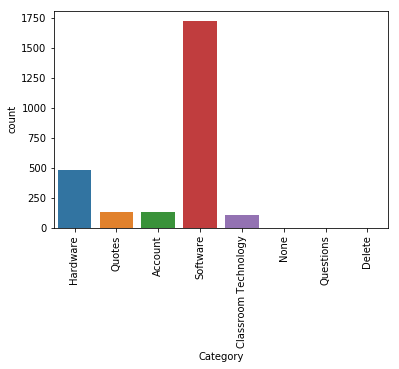

In [25]:
ax = sns.countplot("Category", data = email_df)
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

#### Seeing the ratio of each class

In [26]:
email_df["Category"].value_counts()*100/email_df["Category"].size

Software                66.384940
Hardware                18.555513
Quotes                   5.224741
Account                  5.186323
Classroom Technology     4.341145
Questions                0.153669
Delete                   0.076834
None                     0.076834
Name: Category, dtype: float64

#### We can see that the categories are heavly imbalanced. We will need to account for the imbalance.

#### Lets look at the length of all the tickets and see if we can use that as a feature.

In [27]:
email_df["Feature Length"] = email_df["Feature"].str.len()

In [28]:
gk = email_df.groupby("Category")
gk.mean()

,Feature Length
Category,
Account,332.437037
Classroom Technology,485.548673
Delete,1057.000000
Hardware,364.956522
None,49.500000
Questions,1124.500000
Quotes,756.441176
Software,540.021412


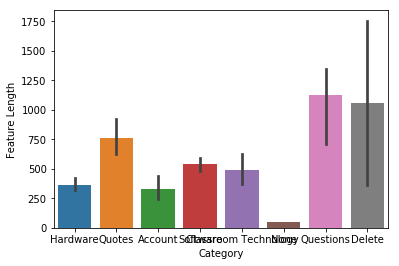

In [29]:
sns.barplot(x = "Category", y = "Feature Length", data = email_df)

#### We will be using length as a feature as well.

## Modeling

#### Converting the classes into numerical representation

In [30]:
dic = {i:j for i, j in zip(email_df["Category"].unique(), range(len(email_df["Category"].unique())))}

In [31]:
email_df["Targets"] = email_df["Category"].map(dic)

#### Looking at our data and seeing where we are.

In [32]:
email_df[["Feature", "Category","Targets"]].head()

,Feature,Category,Targets
41,"Engineering office moves Michael, WE have ...",Hardware,0
42,EVGA UV Plus - Multi-Screen expansion Before...,Quotes,1
44,Printers Please help us disconnect all desk...,Hardware,0
46,Access to previous compliance folders,Account,2
47,Adobe Flash Player installation Good Afterno...,Software,3


#### We will only be using the Feature column for our classification.

In [33]:
X = email_df[["Feature", "Feature Length"]]
# X = email_df["Feature"]
y = email_df["Targets"]

#### Spliting the data for training and testing

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [35]:
x_train["Feature"].head()

5002    COB 251   Hello, The sound and microphone as w...
586     Need help with Outlook Calendar   Hi Guys! I n...
1077    FW: PO for Adobe Acrobat Pro   Im not sure if...
4866    FW: Adobe Acrobat PRO   Hello, I was sent the ...
1762                          Virtual Desktop not working
Name: Feature, dtype: object

#### Fitting the CountVectorizer to the training data

In [36]:
# vect = CountVectorizer()
vect = TfidfVectorizer(ngram_range = (1, 1))

In [37]:
vect = vect.fit(x_train["Feature"])

#### We can see how many features we have.

In [38]:
len(vect.get_feature_names())

10695

#### Transforming our training data into a sparse matrix

In [39]:
x_train_vec = vect.transform(x_train["Feature"])

In [40]:
x_train_vec

<1952x10695 sparse matrix of type '<class 'numpy.float64'>'
	with 94383 stored elements in Compressed Sparse Row format>

#### Adding the length to our sparse matrix

#### We will create a helper function for combining features

In [41]:
def joinSparse(x, y):
    return sc.sparse.hstack([x, np.array([y]).T])

In [42]:
x_train_vec = joinSparse(x_train_vec, x_train["Feature Length"])

In [43]:
x_train_vec.shape

(1952, 10696)

## Classification

#### We will create multiple models and compare there performance.

#### Supervised Learning

In [59]:
logistic_clf = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", random_state = 0, max_iter = 1000)

In [60]:
naive_clf = MultinomialNB(alpha=0.001)

In [61]:
svm_clf = svm.SVC(gamma = 0.1, random_state = 0, kernel = "linear", max_iter = 100000)

In [62]:
knn_clf = KNeighborsClassifier(n_neighbors=20)

In [63]:
rf_clf = RandomForestClassifier(n_estimators=50, max_depth=5,random_state=0)

In [64]:
gb_clf = GradientBoostingClassifier(n_estimators = 50, max_depth = 3, random_state = 0)

In [65]:
clf = [logistic_clf, naive_clf, svm_clf, knn_clf, rf_clf, gb_clf]

clf_dic = ["Logistic", "Naive", "SVM", "KNN", "RandomForest", "GradientBoosting"]

In [67]:
for i in clf:
    i.fit(x_train_vec, y_train)
    print(".")

c:\program files\python\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


.
.


c:\program files\python\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


.
.
.
.


#### Looking at the f1 score of each classifier

In [68]:
# x_test = joinSparse(vect.transform(x_test["Feature"]), x_test["Feature Length"])
for i,j in zip(clf_dic, clf):
    print(f"{i}: {f1_score(j.predict(x_test), y_test, average = 'weighted')}")

Logistic: 0.7849309761731036
Naive: 0.7446138766250835


c:\program files\python\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


SVM: 0.44874437312344706
KNN: 0.7714016305127033
RandomForest: 0.8055045871559633
GradientBoosting: 0.8034371251076008


#### We will look at the top features from each of the classifiers

In [69]:
def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: %s" % (category, " ".join(feature_names[top10])))

In [70]:
show_top10(logistic_clf, vect, email_df["Category"].unique())

Hardware: machine cas office print set move new up disposal printer
Quotes: chromebook university dell acrobat purchase hp order pro for quote
Account: cred employee issue email password change pw name account reset
Software: log login drive outlook shared imagenow image my myuttyler access
Classroom Technology: rbn board sound hate not smart the working in projector
None: request monitor dept ready delivery pros dakota mathematic borrow temporarily
Questions: knimon profnimon zoom as student read write sar goal address
Delete: stated uttua 3988 avery 029687 ritzma aimee when it she


In [71]:
show_top10(naive_clf, vect, email_df["Category"].unique())

IndexError: index 10695 is out of bounds for axis 0 with size 10695

# Further Improvements

#### We can see some of the words that have been associated to different categories. The thing to notice in the Naive classifier is that, "for", "of", "it" and other stop words have been mapped to account category which will need to be removed. Furthermore, in the classroom technology category, "tech", "over", "send" have been mapped, which comes from the system bypassing the prediction process. So, those need to be removed as well. This can be happening with other categories and as such needs further cleanning.

In [ ]:
email_df.head()